In [1]:
# Time steps 10:45:08 -- 10:58:03

# Neural Network Classification with PyTorch

## Notebook Imports

In [2]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch import nn

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
X, y = make_circles(1000, noise=0.03, random_state=42)
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
circles_df = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:, 1],
        'label': y
    }
)

circles_df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


## Data Visualization

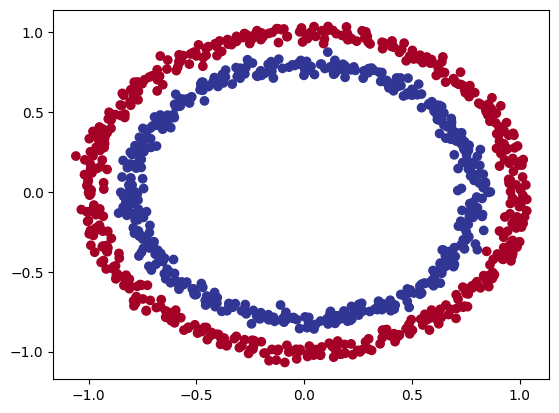

In [5]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Turn the Data into Tensors

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a Model

In [8]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
# Contruct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
model_2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0846,  0.5286],
                      [-0.4382, -0.5005],
                      [ 0.6639,  0.6655],
                      [ 0.1440,  0.3577],
                      [-0.6734,  0.5567]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2134,  0.0602,  0.5454, -0.3956,  0.2626], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3780, -0.4105, -0.4300,  0.1989, -0.3773]], device='cuda:0')),
             ('1.bias', tensor([0.1389], device='cuda:0'))])

In [12]:
# Set up loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss() # has built-in sigmoid activation function
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.1)

In [13]:
# Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100 
    return acc

### Raw Logits -> Prediction Probabilities -> Prediction Labels

Model output are raw **logits** 
<br>
To convert them into **prediction probabilities**, we pass them to some kind of activation functions (sigmoid -> binary classification and softmax -> multiclass classification) 
<br>
Then to convert them into **prediction labels**, we round them or use `argmax()`

In [14]:
model_2.eval()

with torch.inference_mode():
    y_logits = model_2(X_test.to(device))[:5]    
y_logits

tensor([[-0.5581],
        [-0.6177],
        [-0.1874],
        [-0.6640],
        [ 0.1529]], device='cuda:0')

In [15]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3640],
        [0.3503],
        [0.4533],
        [0.3398],
        [0.5382]], device='cuda:0')

In [16]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_2(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [17]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## Train a Model

1. Forward Pass
2. Calculate the Loss
3. Optimizer zero grad
4. Loss Backward (backpropagation)
5. Optimizer Step (gradient descent)

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    
    # Forward Pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Calculate Loss / Accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # Optimizer Zero Grad
    optimizer.zero_grad()
    
    # Loss Backward
    loss.backward()
    
    # Optimizer Step
    optimizer.step()
    
    # Testing 
    model_2.eval()
    
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%')

Epoch: 0 | Loss: 0.71063 | Accuracy: 46.88% | Test Loss: 0.69396 | Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.69482 | Accuracy: 51.88% | Test Loss: 0.69212 | Test Accuracy: 51.00%
Epoch: 20 | Loss: 0.69314 | Accuracy: 52.25% | Test Loss: 0.69556 | Test Accuracy: 48.50%
Epoch: 30 | Loss: 0.69300 | Accuracy: 51.12% | Test Loss: 0.69467 | Test Accuracy: 46.50%
Epoch: 40 | Loss: 0.69302 | Accuracy: 50.88% | Test Loss: 0.69405 | Test Accuracy: 47.50%
Epoch: 50 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69487 | Test Accuracy: 45.50%
Epoch: 60 | Loss: 0.69298 | Accuracy: 51.50% | Test Loss: 0.69485 | Test Accuracy: 45.50%
Epoch: 70 | Loss: 0.69298 | Accuracy: 51.62% | Test Loss: 0.69458 | Test Accuracy: 46.00%
Epoch: 80 | Loss: 0.69298 | Accuracy: 51.50% | Test Loss: 0.69471 | Test Accuracy: 45.00%
Epoch: 90 | Loss: 0.69298 | Accuracy: 51.25% | Test Loss: 0.69471 | Test Accuracy: 45.50%


## Make Predictions and Evaluation

In [19]:
import requests
from pathlib import Path

In [20]:
if Path('helper_fuctions.py').is_file():
    print('File already exists!')
else:
    print('Downloading!')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

Downloading!


In [21]:
from helper_functions import plot_predictions, plot_decision_boundary

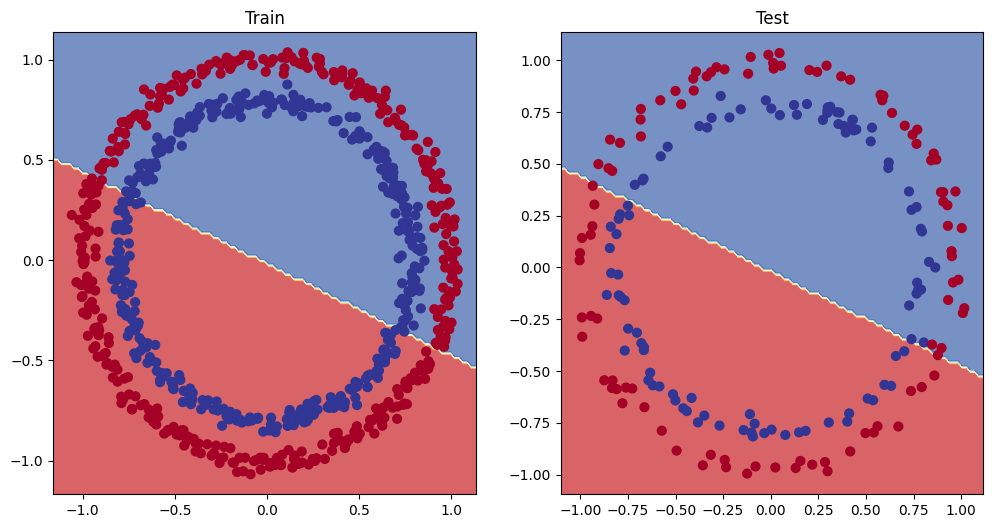

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)